In [22]:
import warnings
warnings.filterwarnings('ignore')


#  Import Libraries

In [23]:
# Basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random


# Load the Dataset

In [24]:
# Load your CSV file
Ev = pd.read_csv('Synthetic_EV_Battery_Breakdown_123.csv')

# Quick overview of the data
Ev.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   battery_current         10000 non-null  float64
 1   extra_load_kg           10000 non-null  float64
 2   vehicle_model           10000 non-null  object 
 3   c_rating                10000 non-null  float64
 4   charge_cycles_weekly    10000 non-null  int64  
 5   age_of_ev_years         10000 non-null  int64  
 6   driving_conditions      10000 non-null  object 
 7   charging_type           10000 non-null  object 
 8   outside_temp_c          10000 non-null  float64
 9   auxiliary_load_percent  10000 non-null  float64
 10  reduced_range_km        10000 non-null  float64
 11  battery_breakdown       10000 non-null  object 
dtypes: float64(6), int64(2), object(4)
memory usage: 937.6+ KB


# Rename Columns

In [25]:
# Safer way to rename columns if keys exist
renaming_dict = {
    'Battery Charging Time (in hours)': 'Battery_Charging_Time',
    'Range (in km)': 'Range_km',
    'Top Speed (in kmph)': 'Top_Speed',
    'Fast Charging Support': 'Fast_Charging_Support',
    'Battery Capacity (in kWh)': 'Battery_Capacity',
    'Charging Cycle': 'Charging_Cycle',
    'Temperature (in Celsius)': 'Temperature',
    'Driving Style': 'Driving_Style',
    'Battery Health (%)': 'Battery_Health',
    'State of Charge (%)': 'State_of_Charge',
    'Power Consumption (in Wh/km)': 'Power_Consumption',
    'Vehicle Type': 'Vehicle_Type'
}

Ev.rename(columns={k: v for k, v in renaming_dict.items() if k in Ev.columns}, inplace=True)


# Null Value Check

In [26]:
Ev.isnull().sum()


battery_current           0
extra_load_kg             0
vehicle_model             0
c_rating                  0
charge_cycles_weekly      0
age_of_ev_years           0
driving_conditions        0
charging_type             0
outside_temp_c            0
auxiliary_load_percent    0
reduced_range_km          0
battery_breakdown         0
dtype: int64

# Check Categorical and Numerical Variables

In [27]:
# Categorical variables
categorical_features = Ev.select_dtypes(include='object').columns
print("Categorical Features:\n", categorical_features)

# Numerical variables
numerical_features = Ev.select_dtypes(include=['int64', 'float64']).columns
print("\nNumerical Features:\n", numerical_features)


Categorical Features:
 Index(['vehicle_model', 'driving_conditions', 'charging_type',
       'battery_breakdown'],
      dtype='object')

Numerical Features:
 Index(['battery_current', 'extra_load_kg', 'c_rating', 'charge_cycles_weekly',
       'age_of_ev_years', 'outside_temp_c', 'auxiliary_load_percent',
       'reduced_range_km'],
      dtype='object')


# Label Encoding Categorical Variables

In [28]:
from sklearn.preprocessing import LabelEncoder

# Create individual encoders for each column
vehicle_encoder = LabelEncoder()
Ev['vehicle_model'] = vehicle_encoder.fit_transform(Ev['vehicle_model'])

driving_encoder = LabelEncoder()
Ev['driving_conditions'] = driving_encoder.fit_transform(Ev['driving_conditions'])

charging_encoder = LabelEncoder()
Ev['charging_type'] = charging_encoder.fit_transform(Ev['charging_type'])




# Correlation Heatmap

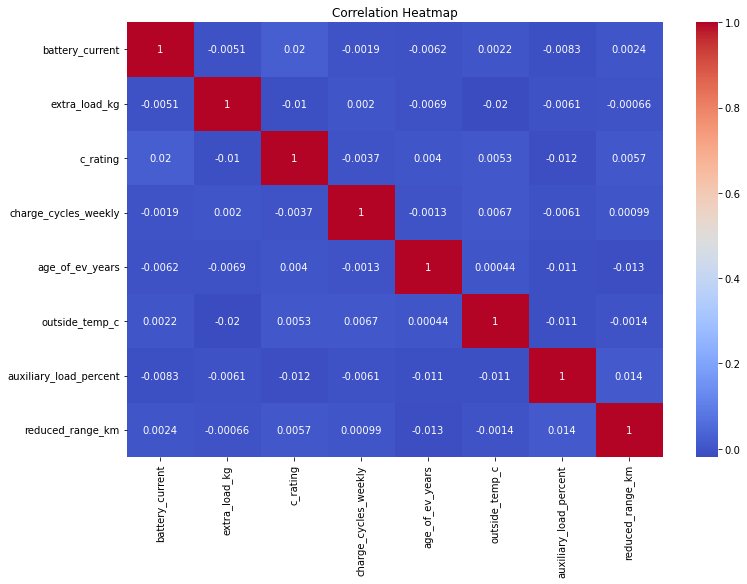

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace with the actual path to your CSV file
df = pd.read_csv('Synthetic_EV_Battery_Breakdown_123.csv')  # Update the path accordingly

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



# EDA - Pairplot

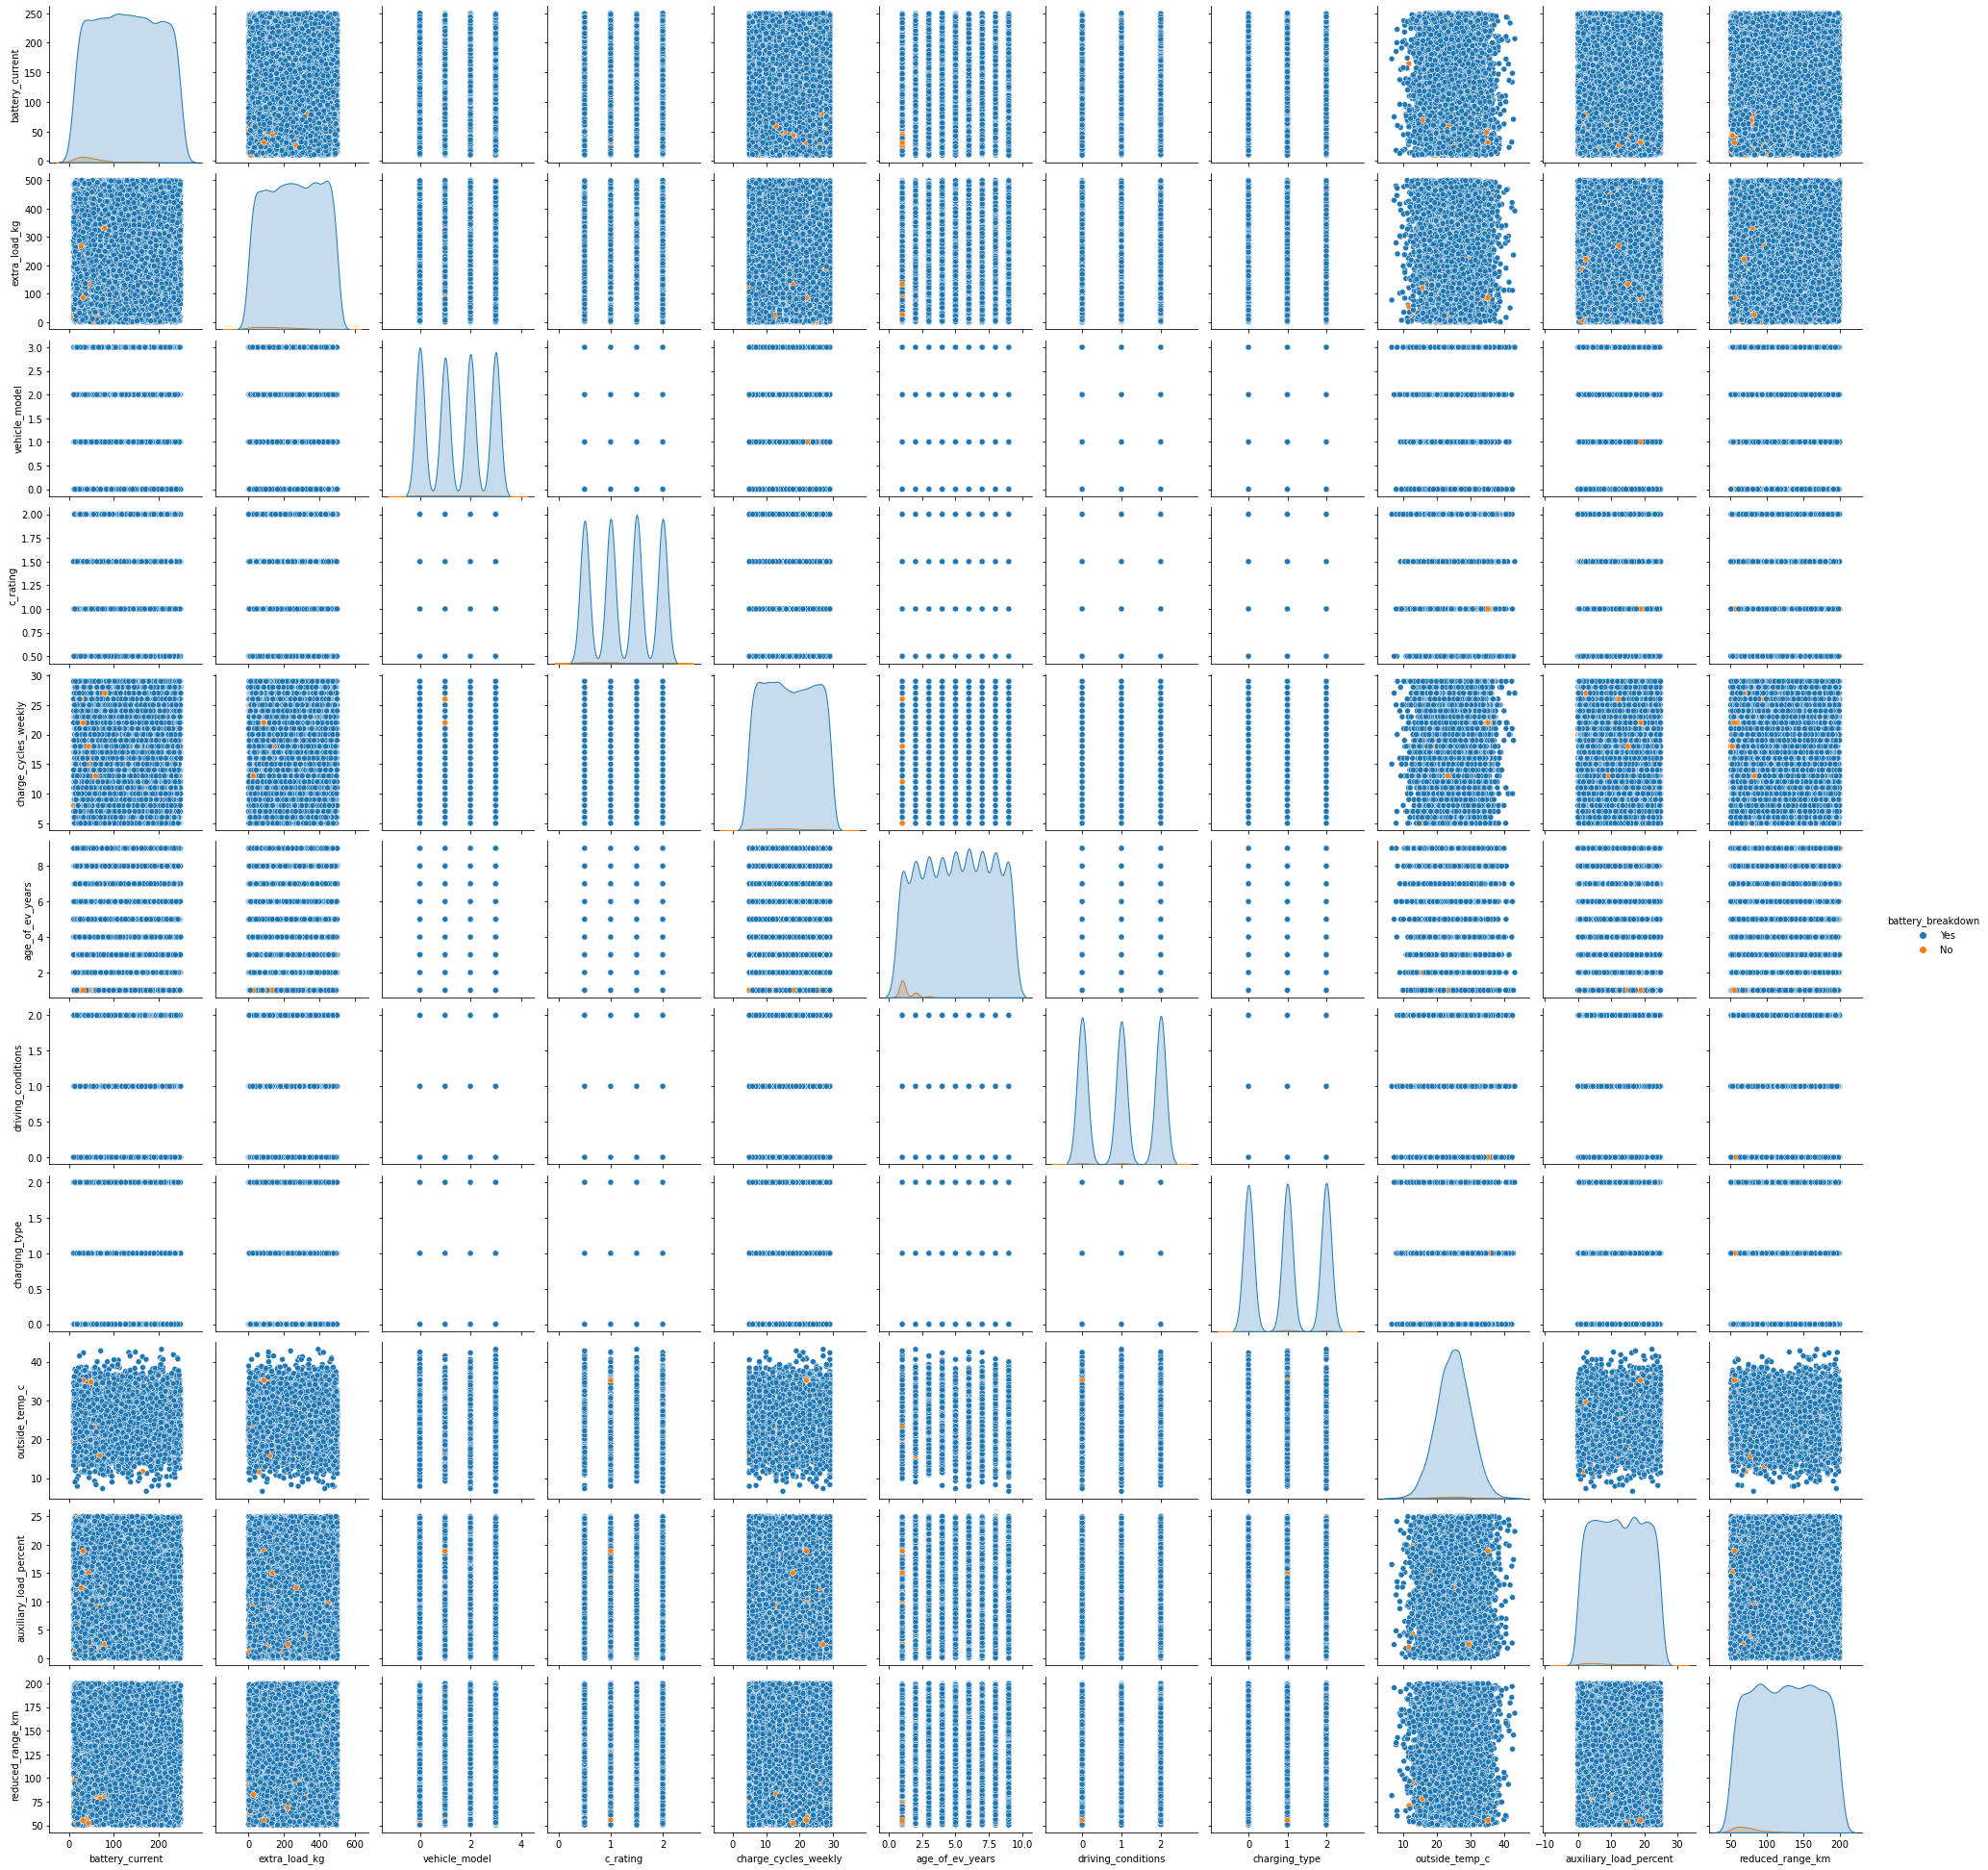

In [30]:
sns.pairplot(Ev, hue='battery_breakdown')  # Using 'battery_breakdown' as the hue column for visualization
plt.show()

# Outlier Handling with Winsorization

In [31]:
from scipy.stats.mstats import winsorize

# Detect and Winsorize numeric columns except target
numeric_cols = Ev.select_dtypes(include=[np.number]).columns.tolist()
if 'Battery_Breakdown' in numeric_cols:
    numeric_cols.remove('Battery_Breakdown')

Ev[numeric_cols] = Ev[numeric_cols].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))



#  Skewness and Kurtosis Checks

In [32]:
from scipy.stats.mstats import winsorize

# Only use numeric features
Ev_numeric = Ev.select_dtypes(include=['float64', 'int64'])

# Apply Winsorization
df_winsor = Ev_numeric.apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Skewness and Kurtosis
print("Skewness:\n", df_winsor.skew(numeric_only=True))
print("Kurtosis:\n", df_winsor.kurtosis(numeric_only=True))



Skewness:
 battery_current           0.024176
extra_load_kg            -0.017364
c_rating                 -0.007243
charge_cycles_weekly      0.019883
age_of_ev_years          -0.022267
outside_temp_c           -0.019297
auxiliary_load_percent    0.009975
reduced_range_km          0.008068
dtype: float64
Kurtosis:
 battery_current          -1.239470
extra_load_kg            -1.245736
c_rating                 -1.348883
charge_cycles_weekly     -1.277909
age_of_ev_years          -1.218055
outside_temp_c           -0.831844
auxiliary_load_percent   -1.255313
reduced_range_km         -1.246124
dtype: float64


#   Outlier Treatment (IQR Method)

In [33]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols = Ev.select_dtypes(include=[np.number]).columns.tolist()
Ev = remove_outliers_iqr(Ev, numerical_cols)

Ev.shape  # Check new shape after outlier removal


(10000, 12)

# Data Balancing (RandomOverSampler)

In [34]:
!pip install imbalanced-learn


In [35]:
from imblearn.over_sampling import RandomOverSampler

if 'Battery_Breakdown' in Ev.columns:
    X = Ev.drop('Battery_Breakdown', axis=1)
    y = Ev['Battery_Breakdown']
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)


#   Train-Test Split

In [36]:
from sklearn.model_selection import train_test_split

# Check the columns in the dataset to find the correct column name for the target
print("Columns in the dataset:", Ev.columns)

# Assuming 'battery_breakdown' is the target column instead of 'Class'
X = Ev.drop(columns='battery_breakdown')  # Replace 'Class' with the correct column name
y = Ev['battery_breakdown']  # Replace 'Class' with the correct target column

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Columns in the dataset: Index(['battery_current', 'extra_load_kg', 'vehicle_model', 'c_rating',
       'charge_cycles_weekly', 'age_of_ev_years', 'driving_conditions',
       'charging_type', 'outside_temp_c', 'auxiliary_load_percent',
       'reduced_range_km', 'battery_breakdown'],
      dtype='object')


# Logistic Regression Model

In [37]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Concatenate X_train and X_test to ensure consistent encoding
X_combined = pd.concat([X_train, X_test])
X_combined_encoded = pd.get_dummies(X_combined, drop_first=True)

# Split them back
X_train_encoded = X_combined_encoded.iloc[:len(X_train), :]
X_test_encoded = X_combined_encoded.iloc[len(X_train):, :]

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_encoded, y_train)

# Predict
y_pred_log = log_reg.predict(X_test_encoded)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Confusion Matrix:
 [[  28   12]
 [   6 2954]]

Classification Report:
               precision    recall  f1-score   support

          No       0.82      0.70      0.76        40
         Yes       1.00      1.00      1.00      2960

    accuracy                           0.99      3000
   macro avg       0.91      0.85      0.88      3000
weighted avg       0.99      0.99      0.99      3000



#  Random Forest Model 

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 👇 Ev should already be encoded earlier in your notebook
# So this part is skipped: loading + label encoding

# Define features and target
X = Ev.drop(columns='battery_breakdown')
y = Ev['battery_breakdown']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("✅ Data split into train and test sets successfully.")

# Random Forest + GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_

# Predict
y_pred_rf = best_rf.predict(X_test)

# Evaluation
print("✅ Best Parameters:\n", grid_search.best_params_)
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n📈 Classification Report:\n", classification_report(y_test, y_pred_rf))


✅ Data split into train and test sets successfully.
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Best Parameters:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

📊 Confusion Matrix:
 [[  13   27]
 [   1 2959]]

📈 Classification Report:
               precision    recall  f1-score   support

          No       0.93      0.33      0.48        40
         Yes       0.99      1.00      1.00      2960

    accuracy                           0.99      3000
   macro avg       0.96      0.66      0.74      3000
weighted avg       0.99      0.99      0.99      3000



# Support Vector Machine (SVM)

In [39]:
#  Import required libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

#  Assumes Ev and encoders are already defined in previous steps (and properly preprocessed)

# Define features and target
X = Ev.drop(columns='battery_breakdown')
y = Ev['battery_breakdown']

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(" Data split into train and test sets successfully.")

#  SVM Model with GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm_model = SVC()
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)

#  Predict and evaluate
y_pred = grid_svm.predict(X_test)
print(" SVM Classification Report:\n")
print(classification_report(y_test, y_pred))




 Data split into train and test sets successfully.
 SVM Classification Report:

              precision    recall  f1-score   support

          No       0.85      0.70      0.77        40
         Yes       1.00      1.00      1.00      2960

    accuracy                           0.99      3000
   macro avg       0.92      0.85      0.88      3000
weighted avg       0.99      0.99      0.99      3000



# Train XGBoost Model

In [40]:
!pip install xgboost

In [44]:
# ✅ Import required libraries
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# ❗ Assumes 'Ev' DataFrame is already preprocessed (except for label encoding)

# ✅ Encode target labels ('No' = 0, 'Yes' = 1)
Ev['battery_breakdown'] = Ev['battery_breakdown'].map({'No': 0, 'Yes': 1})

# ✅ Define features and target
X = Ev.drop(columns='battery_breakdown')
y = Ev['battery_breakdown']

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("✅ Data split into train and test sets successfully.")

# ✅ Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# ✅ Initialize XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# ✅ Grid search with 5-fold cross-validation
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5)
grid_xgb.fit(X_train, y_train)

# ✅ Predict and evaluate
y_pred = grid_xgb.predict(X_test)
print("✅ Best Parameters Found:", grid_xgb.best_params_)
print("\n📊 XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred))




✅ Data split into train and test sets successfully.
✅ Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

📊 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.57      0.70        40
           1       0.99      1.00      1.00      2960

    accuracy                           0.99      3000
   macro avg       0.94      0.79      0.85      3000
weighted avg       0.99      0.99      0.99      3000



# Model Evaluation

In [45]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import pickle

# Load example dataset (replace with your own)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestClassifier()
svm_model = SVC(probability=True)  # Enable probability for ROC curve
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
log_model = LogisticRegression(max_iter=1000)

# Fit models
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
log_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_log = log_model.predict(X_test)

# Evaluation metrics function
def get_metrics(model_name, y_true, y_pred):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    }

# Results collection
results = [
    get_metrics("Random Forest", y_test, y_pred_rf),
    get_metrics("SVM", y_test, y_pred_svm),
    get_metrics("XGBoost", y_test, y_pred_xgb),
    get_metrics("Logistic Regression", y_test, y_pred_log)
]

# Display comparison table
comparison_df = pd.DataFrame(results)
print("\n🔍 Model Performance Comparison:")
print(comparison_df)



🔍 Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.964912   0.965205  0.964912  0.964738
1                  SVM  0.947368   0.951470  0.947368  0.946462
2              XGBoost  0.956140   0.956088  0.956140  0.956036
3  Logistic Regression  0.956140   0.956905  0.956140  0.955801


# ROC Curve + AUC for RF, XGBoost, SVM, and Logistic Regression

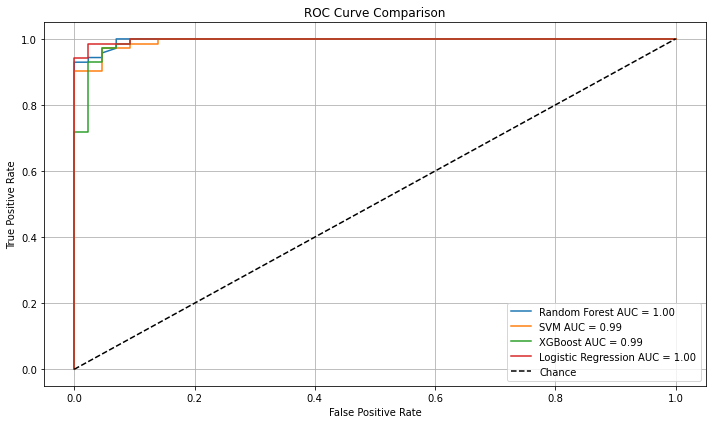

In [46]:
# Imports for ROC curve plotting
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve Plotting
plt.figure(figsize=(10, 6))

# Define a function to plot ROC curve for each model
def plot_roc(model, X_test, y_test, label):
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} AUC = {roc_auc:.2f}')

# Plot ROC curves (Assuming models already trained and named accordingly)
plot_roc(rf_model, X_test, y_test, 'Random Forest')
plot_roc(svm_model, X_test, y_test, 'SVM')
plot_roc(xgb_model, X_test, y_test, 'XGBoost')
plot_roc(log_model, X_test, y_test, 'Logistic Regression')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Importance (XGBoost)

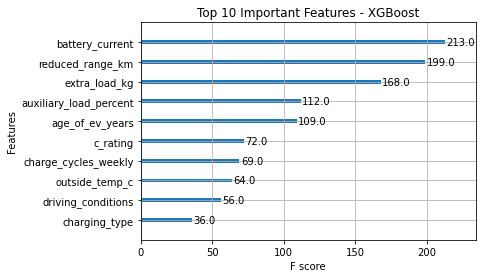

In [47]:
from xgboost import plot_importance

# Plot top 10 important features
plot_importance(grid_xgb.best_estimator_, max_num_features=10)
plt.title("Top 10 Important Features - XGBoost")
plt.show()


# Stratified Train-Test Split (Optional but smart)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)



#  Confusion Matrix Heatmap

y_test shape: (114,), y_pred shape: (114,)


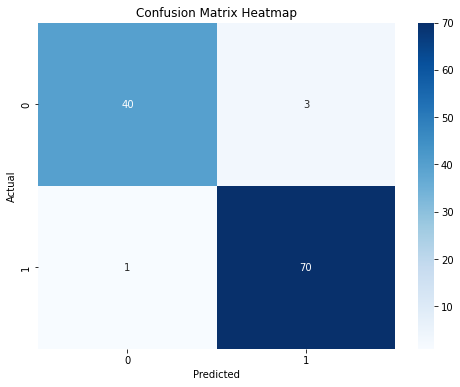

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier  # Example model

# Example data (X, y should be defined earlier)
# X = ...
# y = ...

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example model (you can replace this with your model)
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# After training the model
y_pred = model.predict(X_test)

# Check the shapes of y_test and y_pred
print(f"y_test shape: {y_test.shape}, y_pred shape: {y_pred.shape}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



#  Cross-validation for each model

In [50]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RandomForestClassifier(), X, y, cv=5)
print("Random Forest CV Accuracy:", scores)
print("Mean Score:", scores.mean())


Random Forest CV Accuracy: [0.92105263 0.94736842 0.98245614 0.98245614 0.98230088]
Mean Score: 0.9631268436578171


# Confusion Matrices

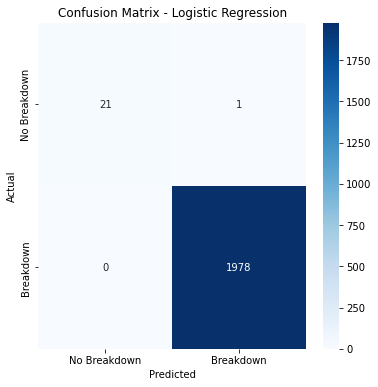

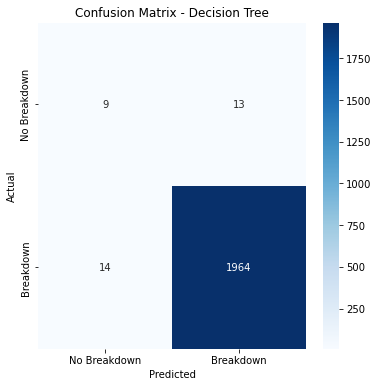

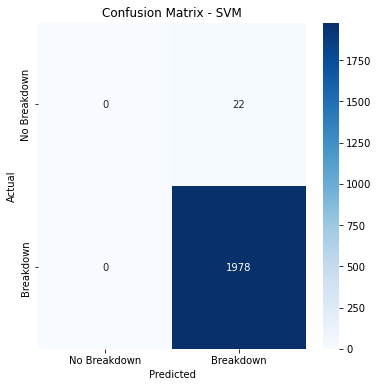

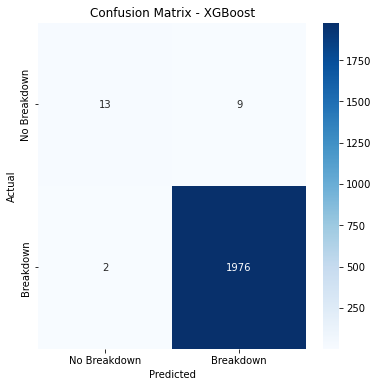

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming 'Ev' is the dataframe containing the dataset)
# Replace this with your actual dataset
Ev = pd.read_csv('Synthetic_EV_Battery_Breakdown_123.csv')

# Ensure that categorical variables are encoded properly
# Perform one-hot encoding for categorical columns (like 'vehicle_model', 'driving_conditions', etc.)
Ev_encoded = pd.get_dummies(Ev, drop_first=True)

# Split the data into features (X) and target (y)
X = Ev_encoded.drop(columns=['battery_breakdown_Yes'])  # Features
y = Ev_encoded['battery_breakdown_Yes']  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
log_reg_model = LogisticRegression(max_iter=1000)
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(probability=True)  # Enable probability for ROC curve
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the models
log_reg_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate confusion matrices for each model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Breakdown', 'Breakdown'], yticklabels=['No Breakdown', 'Breakdown'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_log_reg, "Logistic Regression")
plot_confusion_matrix(conf_matrix_dt, "Decision Tree")
plot_confusion_matrix(conf_matrix_svm, "SVM")
plot_confusion_matrix(conf_matrix_xgb, "XGBoost")


# Hyperparameter Tuning and ROC Curve Code:

Best parameters for Decision Tree:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for XGBoost:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.9}


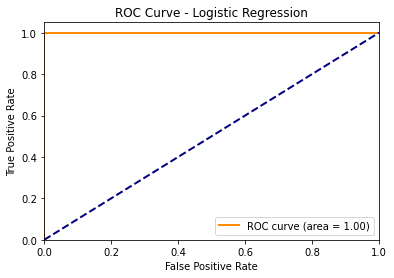

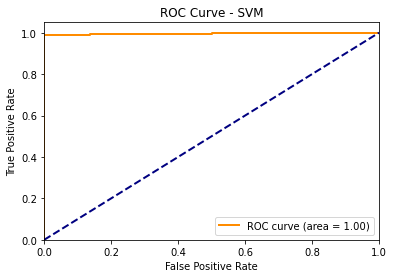

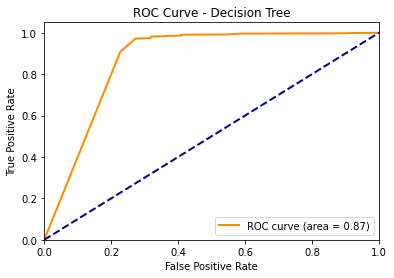

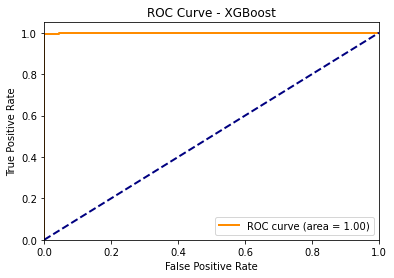

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


# Split the data into features (X) and target (y)
X = Ev_encoded.drop(columns=['battery_breakdown_Yes'])  # Features
y = Ev_encoded['battery_breakdown_Yes']  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
log_reg_model = LogisticRegression(max_iter=1000)
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(probability=True)  # Enable probability for ROC curve
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Hyperparameter tuning for Decision Tree and XGBoost using GridSearchCV
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# Decision Tree tuning
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# XGBoost tuning
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters found for each model
print("Best parameters for Decision Tree: ", grid_search_dt.best_params_)
print("Best parameters for XGBoost: ", grid_search_xgb.best_params_)

# Re-train the models with the best parameters
best_dt_model = grid_search_dt.best_estimator_
best_xgb_model = grid_search_xgb.best_estimator_

# Fit models with best parameters
best_dt_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg_model.fit(X_train, y_train).predict(X_test)
y_pred_svm = svm_model.fit(X_train, y_train).predict(X_test)
y_pred_dt = best_dt_model.predict(X_test)
y_pred_xgb = best_xgb_model.predict(X_test)

# Confusion Matrix for each model (Optional, already discussed)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrices
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Breakdown', 'Breakdown'], yticklabels=['No Breakdown', 'Breakdown'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC Curves
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Calculate ROC curves for each model
def get_roc_curve(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc, model_name)

# Plot ROC for all models
get_roc_curve(log_reg_model, X_test, y_test, "Logistic Regression")
get_roc_curve(svm_model, X_test, y_test, "SVM")
get_roc_curve(best_dt_model, X_test, y_test, "Decision Tree")
get_roc_curve(best_xgb_model, X_test, y_test, "XGBoost")


#  Hyperparameter Tuning Results Graph

Best parameters for Decision Tree:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for XGBoost:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.9}


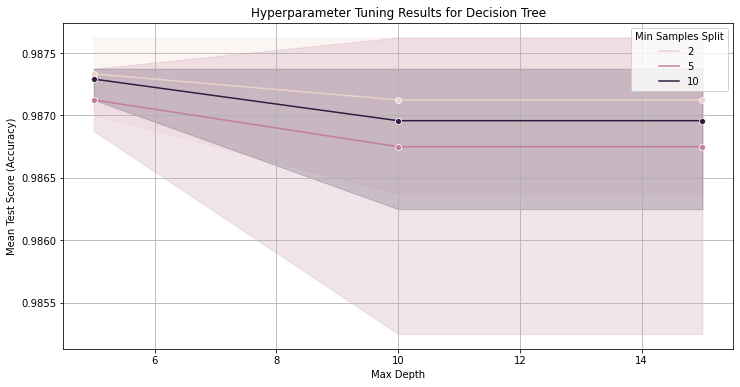

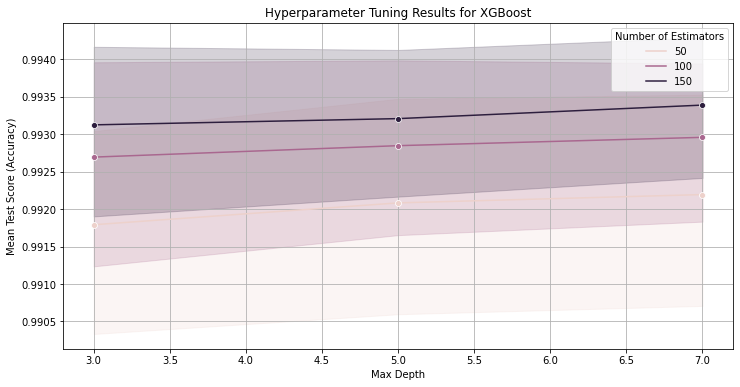

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into features (X) and target (y)
X = Ev_encoded.drop(columns=['battery_breakdown_Yes'])  # Features
y = Ev_encoded['battery_breakdown_Yes']  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='accuracy', return_train_score=True)
grid_search_dt.fit(X_train, y_train)

# GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy', return_train_score=True)
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters for each model
print("Best parameters for Decision Tree: ", grid_search_dt.best_params_)
print("Best parameters for XGBoost: ", grid_search_xgb.best_params_)

# Create DataFrames for the results
dt_results = pd.DataFrame(grid_search_dt.cv_results_)
xgb_results = pd.DataFrame(grid_search_xgb.cv_results_)

# Plot the hyperparameter tuning results for Decision Tree
plt.figure(figsize=(12, 6))
sns.lineplot(data=dt_results, x='param_max_depth', y='mean_test_score', hue='param_min_samples_split', marker='o')
plt.title("Hyperparameter Tuning Results for Decision Tree")
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (Accuracy)')
plt.legend(title='Min Samples Split')
plt.grid(True)
plt.show()

# Plot the hyperparameter tuning results for XGBoost
plt.figure(figsize=(12, 6))
sns.lineplot(data=xgb_results, x='param_max_depth', y='mean_test_score', hue='param_n_estimators', marker='o')
plt.title("Hyperparameter Tuning Results for XGBoost")
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (Accuracy)')
plt.legend(title='Number of Estimators')
plt.grid(True)
plt.show()


# Save Your Model

In [56]:
import joblib

# Save model, encoded columns, and encoders for use in the Flask app
model_data = {
    'model': best_rf,
    'columns': X.columns.tolist(),
    'encoders': encoders  # This contains all LabelEncoders by column
}

joblib.dump(model_data, 'random_forest_model.pkl')
print("Model and encoders saved successfully.")


Model and encoders saved successfully.


In [57]:
# 🔁 Step 1: Import Libraries
import pandas as pd
import numpy as np
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output

# 🔁 Step 2: Load Your Trained Model Bundle
model_bundle = joblib.load('random_forest_model.pkl')
model = model_bundle['model']
ordered_columns = model_bundle['columns']
encoders = model_bundle['encoders']  # if you're using label encoders, not used below but useful

# 🔁 Step 3: Define Widgets for Inputs
battery_current = widgets.FloatText(description="Battery Current (A):")
extra_load_kg = widgets.FloatText(description="Extra Load (kg):")
vehicle_model = widgets.Dropdown(options=["Model A", "Model B", "Model C", "Model D"], description="Vehicle Model:")
c_rating = widgets.FloatText(description="C Rating:")
charge_cycles_weekly = widgets.FloatText(description="Charge Cycles/Wk:")
age_of_ev_years = widgets.FloatText(description="EV Age (yrs):")
driving_conditions = widgets.Dropdown(options=["city", "highway", "hill road"], description="Driving Type:")
charging_type = widgets.Dropdown(options=["Level 1", "Level 2", "Level 3"], description="Charging Type:")
outside_temp_c = widgets.FloatText(description="Temp (°C):")
auxiliary_load_percent = widgets.FloatText(description="Aux Load (%):")
reduced_range_km = widgets.FloatText(description="Reduced Range (km):")

output = widgets.Output()
predict_btn = widgets.Button(description="🔍 Predict Breakdown", button_style='success')

# 🔁 Step 4: Define Prediction Function
def on_predict_clicked(b):
    output.clear_output()
    with output:
        # ✅ Create Input DataFrame from Widget Values
        input_data = {
            'battery_current': [battery_current.value],
            'extra_load_kg': [extra_load_kg.value],
            'c_rating': [c_rating.value],
            'charge_cycles_weekly': [charge_cycles_weekly.value],
            'age_of_ev_years': [age_of_ev_years.value],
            'outside_temp_c': [outside_temp_c.value],
            'auxiliary_load_percent': [auxiliary_load_percent.value],
            'reduced_range_km': [reduced_range_km.value],
            'vehicle_model': [vehicle_model.value],
            'driving_conditions': [driving_conditions.value],
            'charging_type': [charging_type.value]
        }

        df = pd.DataFrame(input_data)

        # ✅ One-hot encode categorical variables
        df_encoded = pd.get_dummies(df)

        # ✅ Add any missing expected columns (from training)
        for col in ordered_columns:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

        # ✅ Ensure proper order of columns
        df_encoded = df_encoded.reindex(columns=ordered_columns, fill_value=0)

        # ✅ Make Prediction
        prediction = model.predict(df_encoded)[0]
        prediction_text = "⚠️ Battery Breakdown Likely! - Yes" if prediction == 1 else "✅ Battery Breakdown Not Likely! - No"

        # ✅ Display Prediction
        print("\n📢 Prediction Result:")
        print(prediction_text)

# 🔁 Step 5: Link the Button to the Prediction Function
predict_btn.on_click(on_predict_clicked)

# 🔁 Step 6: Display the Form
form = widgets.VBox([
    widgets.HTML("<h2 style='color:teal;'>🔋 EV Battery Breakdown Prediction Form</h2>"),
    battery_current,
    extra_load_kg,
    vehicle_model,
    c_rating,
    charge_cycles_weekly,
    age_of_ev_years,
    driving_conditions,
    charging_type,
    outside_temp_c,
    auxiliary_load_percent,
    reduced_range_km,
    predict_btn,
    output
])

display(form)

